In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.pyplot import tight_layout
from kneed import KneeLocator

def HSVToRGB(h, s, v): 
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v) 
    return (r, g, b) 

def getDistinctColors(n): 
    huePartition = 1.0 / (n + 1) 
    return [HSVToRGB(huePartition * value, 1.0, 1.0) for value in range(0, n)]

colors = getDistinctColors(20)

# Load Data
clustering_df = pd.read_csv("../data/clustering_common_variables_la_fe.csv")
clustering_df = clustering_df.set_index(["protocol_id", "patient_id"])
metadata_df = pd.read_csv("../data/clustering_metadata_la_fe.csv")
clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397 entries, 0JQDMK44FDMVKkU0GBgw to zdjn6E90MG6KaxXZDRLs
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   death                  397 non-null    float64
 1   hospitalization        397 non-null    float64
 2   eat_well               397 non-null    float64
 3   is_vomiting            397 non-null    float64
 4   sleep_well             397 non-null    float64
 5   ER_contact             397 non-null    float64
 6   medication_change      397 non-null    float64
 7   has_dyspnoea           397 non-null    float64
 8   has_pain               397 non-null    float64
 9   pain_med               397 non-null    float64
 10  urine_well             397 non-null    float64
 11  urine_pain             397 non-null    float64
 12  urine_blood            397 non-null    float64
 13  has_constipation       397 non-null    float64
 14  constipation_days      397 

In [2]:
var_list = list(clustering_df.columns)
X = clustering_df.to_numpy()
N, D = X.shape 
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [3]:
# Test K-Means
cluster_range = np.arange(2, 50)
inertias = []
silhouettes = []
for k in cluster_range:
    model = KMeans(n_clusters=k)
    model.fit(X_std)
    inertias.append(model.inertia_/X_std.shape[0])
    silhouettes.append(silhouette_score(X_std, model.labels_))

Inertia knee-point at 23 components.
Silhouette knee-point at 11 components.


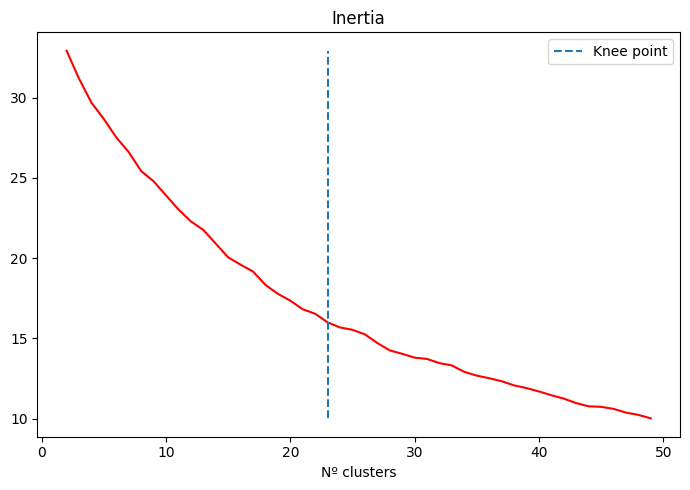

In [4]:
silhouettes_smooth = savgol_filter(silhouettes, 30, 3)

kn_iner = KneeLocator(cluster_range, inertias, curve='convex', direction='decreasing')
kn_silh = KneeLocator(cluster_range, silhouettes_smooth, curve='convex', direction='decreasing')

fig, ax1 = plt.subplots(figsize=(7, 5), tight_layout=True)
ax1.plot(cluster_range, inertias, color="red")
ax1.vlines(kn_iner.knee, min(inertias), max(inertias), linestyles='dashed', label="Knee point")
ax1.legend()
ax1.set_xlabel("Nº clusters")
ax1.set_title("Inertia")

#ax2.plot(cluster_range, silhouettes, ".--", color="grey")
#ax2.plot(cluster_range, silhouettes_smooth, color="red")
#ax2.vlines(kn_silh.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', label="Knee point")
#ax2.legend()
#ax2.set_xlabel("Nº clusters")
#ax2.set_title("Silhouette")

print(f"Inertia knee-point at {kn_iner.knee} components.")
print(f"Silhouette knee-point at {kn_silh.knee} components.")

Text(0.5, 1.0, 'AIC')

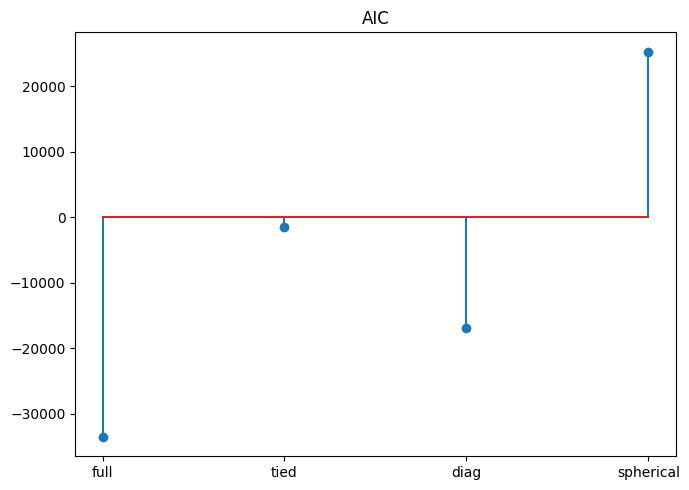

In [5]:
# Test GMM covariance shape
BICs = []
AICs = []
covars = ["full", "tied", "diag", "spherical"]
k = 10
for covar in covars:
    model = GMM(n_components=k, covariance_type=covar)
    model.fit(X_std)
    bic = model.bic(X_std)
    aic = model.aic(X_std)
    BICs.append(bic)
    AICs.append(aic)

fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=(7,5))
ax.stem(AICs)
ax.set_xticks(range(4))
ax.set_xticklabels(covars)
ax.set_title("AIC")

In [6]:
# Test GMM Nº componenets
from matplotlib.pyplot import tight_layout

cluster_range = np.arange(2, 50)
BICs = []
AICs = []
for k in cluster_range:
    model = GMM(n_components=k, covariance_type="full")
    model.fit(X_std)
    bic = model.bic(X_std)
    aic = model.aic(X_std)
    BICs.append(bic)
    AICs.append(aic)

AIC minimum at 11 components.


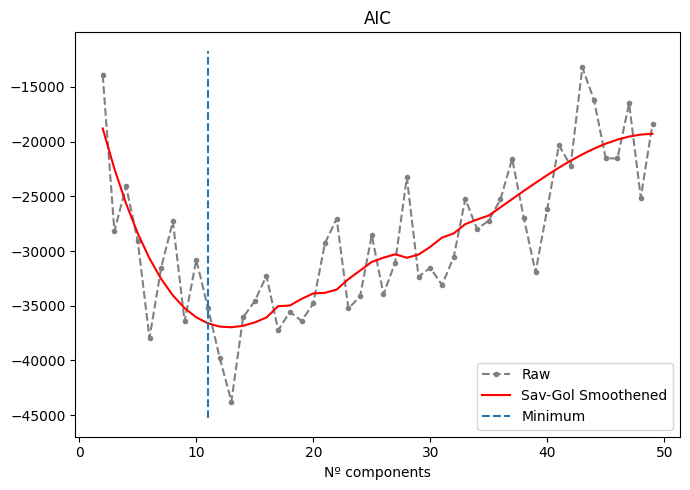

In [7]:
BICs_smooth = savgol_filter(BICs, 30, 3)
AICs_smooth = savgol_filter(AICs, 30, 3)
n_components_gmm = AICs_smooth.argmin()

fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=(7,5))
ax.plot(cluster_range, AICs, ".--", color="grey", label="Raw")
ax.plot(cluster_range, AICs_smooth, color="red", label="Sav-Gol Smoothened")
ax.vlines(n_components_gmm, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', label="Minimum")
ax.legend(loc=4)
ax.set_xlabel("Nº components")
ax.set_title("AIC")

print(f"AIC minimum at {n_components_gmm} components.")

In [8]:
model = GMM(n_components=n_components_gmm, covariance_type="full")
labels = model.fit_predict(X_std)
centroids_norm = model.means_
centroids = scaler.inverse_transform(centroids_norm)
cluster_id, cluster_count = np.unique(labels, return_counts=True)

In [9]:

"""
for i in range(n_components_gmm):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(range(D), centroids[i, :])
    ax.set_xticks(range(D))
    ax.set_xticklabels(var_list, rotation = 70, ha="right")
"""

W = 5
for i in range(n_components_gmm):
    top_W_idx = np.argpartition(centroids_norm[i, :], -W)[-W:]
    top_W_vals = centroids_norm[i, top_W_idx]
    top_W_vars = [var_list[i] for i in top_W_idx]
    fig = px.line_polar(
        r=top_W_vals, 
        theta=top_W_vars, 
        line_close=True, 
        title=f"Cluster {cluster_id[i]}, population = {cluster_count[i]}")
    fig.update_traces(fill='toself')
    fig.show()


/home/oscar/Desktop/Tucuvi/source/neotec/env/lib/python3.10/site-packages/plotly/express/_core.py:271: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trace_data = trace_data.append(trace_data.iloc[0])


/home/oscar/Desktop/Tucuvi/source/neotec/env/lib/python3.10/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/home/oscar/Desktop/Tucuvi/source/neotec/env/lib/python3.10/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/home/oscar/Desktop/Tucuvi/source/neotec/env/lib/python3.10/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/home/oscar/Desktop/Tucuvi/source/neotec/env/lib/python3.10/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/home/oscar/Desktop/Tucuvi/source/neotec/env/lib/python3.10/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/home/oscar/Desktop/Tucuvi/source/neotec/env/lib/python3.10/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/home/oscar/Desktop/Tucuvi/source/neotec/env/lib/python3.10/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/home/oscar/Desktop/Tucuvi/source/neotec/env/lib/python3.10/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/home/oscar/Desktop/Tucuvi/source/neotec/env/lib/python3.10/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/home/oscar/Desktop/Tucuvi/source/neotec/env/lib/python3.10/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

